In [1]:
from numba import njit
import pandas as pd
import numpy as np

from numba.typed import Dict

from hftbacktest import NONE, NEW, HftBacktest, GTX, FeedLatency, SquareProbQueueModel, BUY, SELL, Linear, Stat

In [2]:
@njit
def gridtrading(hbt, stat, skew):
    while hbt.run:
        # Running interval in microseconds
        if not hbt.elapse(0.1 * 1e6):
            return False
        # Clear cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        # This is an example to show how to use hftbacktest.
        # The stat varies a lot according to the configuration and the market condition.
        max_position = 5
        order_interval = hbt.tick_size * 10
        grid_num = 20
        half_spread = hbt.tick_size * 20
        
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size
        bid_order_begin = np.floor((reservation_price - half_spread) / order_interval) * order_interval
        ask_order_begin = np.ceil((reservation_price + half_spread) / order_interval) * order_interval
        
        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.lot_size) * hbt.lot_size
        last_order_id = -1
        
        # Create a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position: # hbt.position * mid_price < max_notional_position
            p = hbt.position
            for i in range(grid_num):
                bid_order_begin -= i * order_interval
                bid_order_tick = round(bid_order_begin / hbt.tick_size)
                # Do not post buy orders above the best bid.
                if bid_order_tick > hbt.best_bid_tick:
                    continue
                p += order_qty
                # Do not post buy orders that can exceed the maximum position.
                if p >= max_position:
                    continue
                # order price in tick is used as order id.
                new_bid_orders[bid_order_tick] = bid_order_begin
        for order in hbt.orders.values():
            # Cancel if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_bid_orders.items():
            # Post an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # Create a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position: # hbt.position * mid_price > -max_notional_position
            p = hbt.position
            for i in range(grid_num):
                ask_order_begin += i * order_interval
                ask_order_tick = round(ask_order_begin / hbt.tick_size)
                # Do not post sell orders below the best ask.
                if ask_order_tick < hbt.best_ask_tick:
                    continue
                p += order_qty
                # Do not post sell orders that can exceed the maximum position.
                if p <= -max_position:
                    continue
                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_begin
        for order in hbt.orders.values():
            # Cancel if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_ask_orders.items():
            # Post an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # All order requests are considered to be requested at the same time.
        # Wait until one of the order responses is received.
        if last_order_id >= 0:
            if not hbt.wait_order_response(last_order_id):
                return False
        
        # Record the current state for stat calculation.
        stat.record(hbt)
    return True

# No Skew

In [3]:
# data file
# https://github.com/nkaz001/collect-binancefutures

# This backtest assumes market maker rebates.
# https://www.binance.com/en/support/announcement/5d3a662d3ace4132a95e77f6ab0f5422

hbt = HftBacktest(['data/ethusdt_20221003.npz',
                   'data/ethusdt_20221004.npz',
                   'data/ethusdt_20221005.npz',
                   'data/ethusdt_20221006.npz',
                   'data/ethusdt_20221007.npz'],
                  tick_size=0.01,
                  lot_size=0.001,
                  maker_fee=-0.00005,
                  taker_fee=0.0007,
                  order_latency=FeedLatency(),
                  queue_model=SquareProbQueueModel(),
                  asset_type=Linear,
                  snapshot='data/ethusdt_20221002_eod.npz')

stat = Stat(hbt)
skew = 0
gridtrading(hbt, stat.recorder, skew)

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz


False

=========== Summary ===========
Sharpe ratio: 22.7
Sortino ratio: 24.4
Risk return ratio: 234.0
Annualised return: 2660.67 %
Max. draw down: 11.37 %
The number of trades per day: 6536
Avg. daily trading volume: 653
Avg. daily trading amount: 876837
Max leverage: 4.20
Median leverage: 1.65


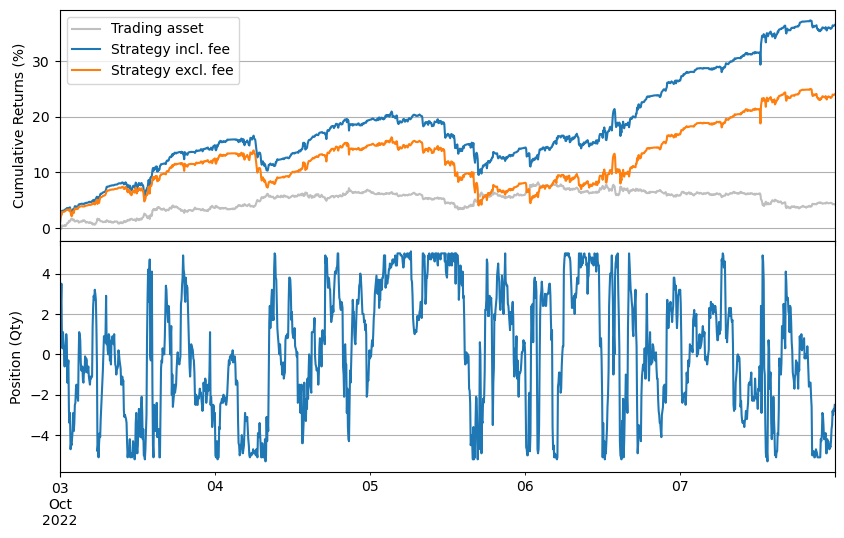

In [4]:
stat.summary(capital=2000)

# Weak Skew

In [5]:
hbt = HftBacktest(['data/ethusdt_20221003.npz',
                   'data/ethusdt_20221004.npz',
                   'data/ethusdt_20221005.npz',
                   'data/ethusdt_20221006.npz',
                   'data/ethusdt_20221007.npz'],
                  tick_size=0.01,
                  lot_size=0.001,
                  maker_fee=-0.00005,
                  taker_fee=0.0007,
                  order_latency=FeedLatency(),
                  queue_model=SquareProbQueueModel(),
                  asset_type=Linear,
                  snapshot='data/ethusdt_20221002_eod.npz')

stat = Stat(hbt)
skew = 1
gridtrading(hbt, stat.recorder, skew)

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz


False

=========== Summary ===========
Sharpe ratio: 19.8
Sortino ratio: 18.6
Risk return ratio: 196.0
Annualised return: 1389.97 %
Max. draw down: 7.09 %
The number of trades per day: 7102
Avg. daily trading volume: 710
Avg. daily trading amount: 953056
Max leverage: 3.75
Median leverage: 0.74


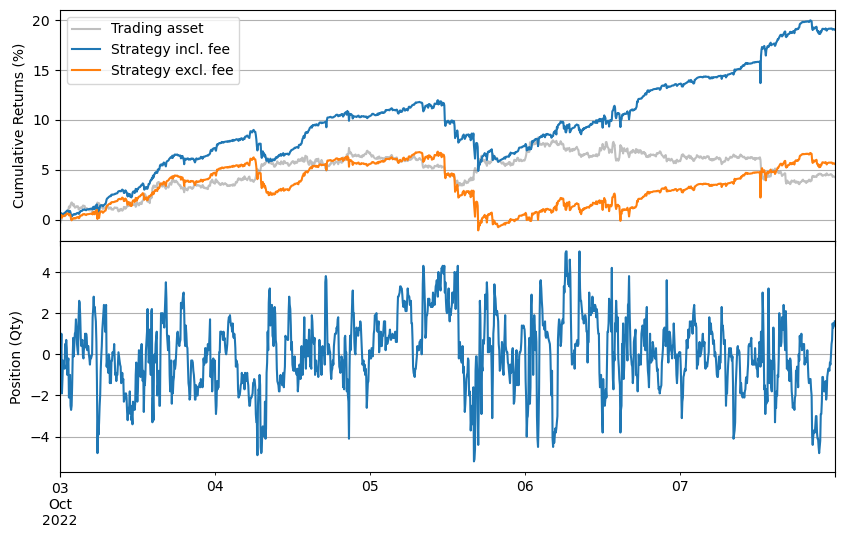

In [6]:
stat.summary(capital=2000)

# Strong Skew

In [7]:
hbt = HftBacktest(['data/ethusdt_20221003.npz',
                   'data/ethusdt_20221004.npz',
                   'data/ethusdt_20221005.npz',
                   'data/ethusdt_20221006.npz',
                   'data/ethusdt_20221007.npz'],
                  tick_size=0.01,
                  lot_size=0.001,
                  maker_fee=-0.00005,
                  taker_fee=0.0007,
                  order_latency=FeedLatency(),
                  queue_model=SquareProbQueueModel(),
                  asset_type=Linear,
                  snapshot='data/ethusdt_20221002_eod.npz')

stat = Stat(hbt)
skew = 10
gridtrading(hbt, stat.recorder, skew)

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz


False

=========== Summary ===========
Sharpe ratio: 29.3
Sortino ratio: 25.7
Risk return ratio: 560.8
Annualised return: 751.18 %
Max. draw down: 1.34 %
The number of trades per day: 7612
Avg. daily trading volume: 761
Avg. daily trading amount: 1021460
Max leverage: 4.06
Median leverage: 0.14


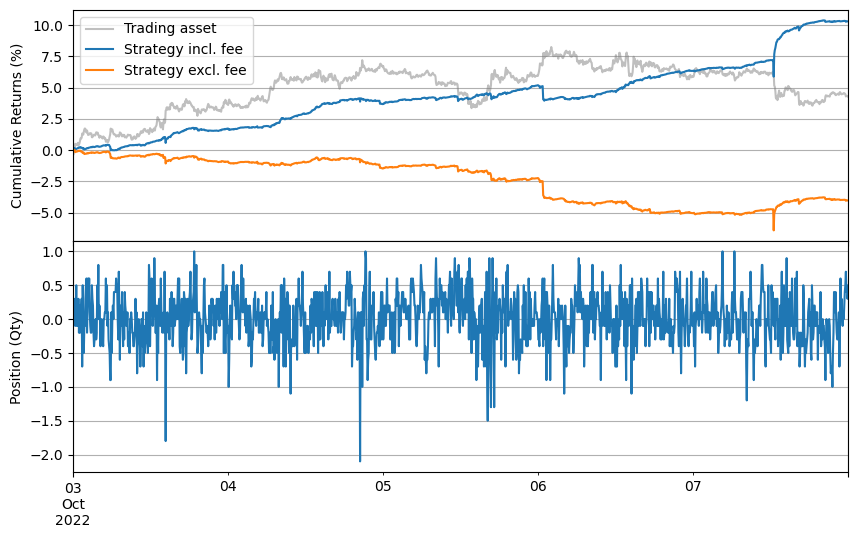

In [8]:
stat.summary(capital=2000)